<a href="https://colab.research.google.com/github/vinixcollen/ML-heart-disease-diagnosis/blob/main/Heart_Disease_Diagnosis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2: Heart Disease Diagnosis Model



##Problem Definition

**Problem Definition:**

According to World Health Organisation (WHO) (2025), cardiovascular diseases (CVDs) are the leading cause of death globally, with early detection being critical for effective intervention and treatment. Current diagnostic protocols often rely on expensive tests like angiograms and require specialist interpretation, creating barriers to accessibility, especially in primary care settings and underserved communities.

**Objective:**

Develop a binary classification system that accurately predicts the presence of heart disease using 13 readily available clinical features, serving as an accessible screening tool to assist healthcare providers in making informed referral decisions.

##Task Specification

###Input Specification

**Data Source:** [UCI Heart Disease Dataset](https://archive.ics.uci.edu/dataset/45/heart+disease)

**Feature Set** (13 clinical parameters):
1. age (years)
2. sex (male/female)
3. chest pain type (typical angina, atypical atypical angina, non-anginal, asymptomatic)
4. Resting blood pressure (mm Hg)
5. Serum cholesterol (mg/dl)
6. Fasting blood sugar > 120 mg/dl (yes / no)
7. Resting ECG results (normal / ST-T abnormality / left ventricular hypertrophy)
8. Maximum heart rate achieved (thalach)
9. Exercise induced angina (yes / no)
10. ST depression induced by exercise relative to rest (oldpeak)
11. Slope of the peak exercise ST segment (upsloping / flat / downsloping)
12. Number of major vessels (0–3) colored by fluoroscopy (ca)
13. Thallium stress test result (thal)

###Output (Target/Label)
The original UCI Heart Disease dataset defines the target variable num as integers from 0 to 4, where 0 indicates no heart disease and 1 - 4 indicate varying degrees of heart disease. For this project, the target was converted into a binary classification problem:
- 0 - No heart disease
- 1 (aggregated from 1, 2, 3, and 4) - Presence of heart diseas



## Data Collection & Preparation

In [1]:
# Install required packages
!pip install ucimlrepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, average_precision_score)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

In [2]:
# Fetch dataset
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

## Data Exploration

In [3]:
# Understand the target variable
print("TARGET VARIABLE ANALYSIS:")
print("Original target values (0-4):")
target_counts = y['num'].value_counts().sort_index()
for val, count in target_counts.items():
    severity = {
        0: "No heart disease",
        1: "Mild disease",
        2: "Moderate disease",
        3: "Severe disease",
        4: "Very severe disease"
    }
    print(f"  {val}: {count} patients ({severity[val]})")

# Convert to binary classification (Clinical decision point)
y_binary = (y['num'] > 0).astype(int)
print(f"\nBinary conversion: {y_binary.value_counts()[0]} healthy vs {y_binary.value_counts()[1]} diseased")
print(f"Disease prevalence: {y_binary.mean():.2%}")

# Analyze feature distributions and missing values
print("\nFEATURE ANALYSIS:")
print("Missing values per feature:")
print(X.isnull().sum())
print(f"Total missing values: {X.isnull().sum().sum()}")

# Basic statistics
print("\nDataset statistics:")
print(f"Total patients: {len(X)}")
print(f"Features available: {len(X.columns)}")
print(f"Data types: {X.dtypes.value_counts().to_dict()}")

TARGET VARIABLE ANALYSIS:
Original target values (0-4):
  0: 164 patients (No heart disease)
  1: 55 patients (Mild disease)
  2: 36 patients (Moderate disease)
  3: 35 patients (Severe disease)
  4: 13 patients (Very severe disease)

Binary conversion: 164 healthy vs 139 diseased
Disease prevalence: 45.87%

FEATURE ANALYSIS:
Missing values per feature:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64
Total missing values: 6

Dataset statistics:
Total patients: 303
Features available: 13
Data types: {dtype('int64'): 10, dtype('float64'): 3}


## Data Preprocessing

### Data Splitting

In [4]:
# First split: 10% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_binary,
    test_size=0.1,
    random_state=42,
    stratify=y_binary
)

# Second split: 22.2% of remaining 90% = 20% of total for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.222,  # 0.222 * 0.9 ≈ 0.20
    random_state=42,
    stratify=y_train_val
)

print("70-20-10 Split Completed:")
print(f"Training set:   {X_train.shape[0]} patients ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} patients ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} patients ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nDisease prevalence:")
print(f"Training:   {y_train.mean():.2%} ({y_train.sum()}/{len(y_train)})")
print(f"Validation: {y_val.mean():.2%} ({y_val.sum()}/{len(y_val)})")
print(f"Test:       {y_test.mean():.2%} ({y_test.sum()}/{len(y_test)})")

70-20-10 Split Completed:
Training set:   211 patients (69.6%)
Validation set: 61 patients (20.1%)
Test set:       31 patients (10.2%)

Disease prevalence:
Training:   45.97% (97/211)
Validation: 45.90% (28/61)
Test:       45.16% (14/31)


### Missing Value

In [5]:
# Create copies to avoid modifying originals
X_train_clean = X_train.copy()
X_val_clean = X_val.copy()
X_test_clean = X_test.copy()

In [6]:
# Learn imputation values from TRAINING set only
ca_mode_train = X_train_clean['ca'].mode()[0]
thal_mode_train = X_train_clean['thal'].mode()[0]

print(f"   Training mode for 'ca': {ca_mode_train}")
print(f"   Training mode for 'thal': {thal_mode_train}")

# Apply to ALL sets using TRAINING values
for dataset, name in [(X_train_clean, 'Training'), (X_val_clean, 'Validation'), (X_test_clean, 'Test')]:
    dataset['ca'].fillna(ca_mode_train, inplace=True)
    dataset['thal'].fillna(thal_mode_train, inplace=True)
    missing_after = dataset.isnull().sum().sum()
    print(f"   {name}: {missing_after} missing values remaining")

   Training mode for 'ca': 0.0
   Training mode for 'thal': 3.0
   Training: 0 missing values remaining
   Validation: 0 missing values remaining
   Test: 0 missing values remaining


/tmp/ipython-input-3366214759.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['ca'].fillna(ca_mode_train, inplace=True)
/tmp/ipython-input-3366214759.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

### Label Encoding

In [7]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
label_encoders = {}

for feature in categorical_features:
    # Fit encoder ONLY on training data
    le = LabelEncoder()
    X_train_clean[feature] = le.fit_transform(X_train_clean[feature])
    label_encoders[feature] = le

    # Transform validation and test using training encoder
    X_val_clean[feature] = le.transform(X_val_clean[feature])
    X_test_clean[feature] = le.transform(X_test_clean[feature])

    print(f"   {feature}: encoded using training categories")


   sex: encoded using training categories
   cp: encoded using training categories
   fbs: encoded using training categories
   restecg: encoded using training categories
   exang: encoded using training categories
   slope: encoded using training categories
   thal: encoded using training categories


## Model Training & Evaluation

Random Forest Model Implementation

In [8]:
# Create a Random Forest classifier with medically-appropriate parameters
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of decision trees in the forest
    max_depth=10,            # Maximum depth of each tree
    min_samples_split=5,     # Minimum samples required to split a node
    min_samples_leaf=2,      # Minimum samples required at a leaf node
    max_features='sqrt',     # Number of features to consider for splitting
    bootstrap=True,          # Use bootstrap sampling (bagging)
    random_state=42,         # For reproducible results
    class_weight='balanced', # Adjust for class imbalance
    verbose=1                # Show training progress
)

#Train the model
# Fitting the model to learn patterns from 212 training patients
# Each tree will learn different aspects of heart disease predictors
rf_model.fit(X_train_clean, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5, random_state=42,
                       verbose=1)

Initial Model Evaluation

In [9]:
# Get predictions for training and validation sets
# Predict on patients model saw during training
y_train_pred = rf_model.predict(X_train_clean)
# Predict on NEW patients (validation set)
y_val_pred = rf_model.predict(X_val_clean)

# Also get probabilities (more detailed than just yes/no)
# Probability of disease
y_train_proba = rf_model.predict_proba(X_train_clean)[:, 1]
y_val_proba = rf_model.predict_proba(X_val_clean)[:, 1]

def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n{dataset_name} Set Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")   #Overall correctness
    print(f"  Precision: {precision:.4f}")  #Of predicted diseased, how many actually diseased?
    print(f"  Recall:    {recall:.4f}")     #Of actually diseased, how many did we catch?
    print(f"  F1-Score:  {f1:.4f}")         #Balance between precision and recall
    print(f"  ROC-AUC:   {auc:.4f}")        #Overall ranking ability

    return accuracy, precision, recall, f1, auc

# Evaluate initial model
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "Validation")

# Check for overfitting
overfit_gap = train_metrics[0] - val_metrics[0]  # Accuracy difference
print(f"\nOverfitting Analysis: Training - Validation = {overfit_gap:.4f}")
if overfit_gap > 0.1:
    print("Potential overfitting detected!")
    print("Model memorized training data but doesn't generalize well")
else:
    print("Model generalization looks good")
    print("Model learned patterns that work on new patients too")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished



Training Set Performance:
  Accuracy:  0.9716
  Precision: 0.9789
  Recall:    0.9588
  F1-Score:  0.9688
  ROC-AUC:   0.9967

Validation Set Performance:
  Accuracy:  0.8361
  Precision: 0.8750
  Recall:    0.7500
  F1-Score:  0.8077
  ROC-AUC:   0.9102

Overfitting Analysis: Training - Validation = 0.1355
Potential overfitting detected!
Model memorized training data but doesn't generalize well


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


###Hyperparameter Tuning

ANALYZING OVERFITTING ISSUE:

Training Accuracy: 97.16% vs Validation Accuracy: 83.61%

Overfitting Gap: 13.55% → Model is too complex, memorizing training data

Recall drop from 95.88% to 75.00% → Missing real disease cases!

TUNING STRATEGY: Reduce model complexity to improve generalization
- Lower max_depth: Simpler trees, less memorization
- Higher min_samples: Require more evidence for decisions
- Optimize n_estimators: Right number of trees

In [10]:
# Define parameter grid focused on reducing overfitting
param_grid = {
    'n_estimators': [50, 100, 150],      # Test fewer/more trees
    'max_depth': [5, 8, 10, None],       # Limit tree complexity
    'min_samples_split': [5, 10, 15],    # Require more patients to split
    'min_samples_leaf': [2, 4, 6],       # Larger leaf sizes
    'max_features': ['sqrt', 'log2']     # Feature subset strategy
}

# PARAMETER GRID FOR OVERFITTING REDUCTION:
for param, values in param_grid.items():
    print(f"  {param}: {values}")

  n_estimators: [50, 100, 150]
  max_depth: [5, 8, 10, None]
  min_samples_split: [5, 10, 15]
  min_samples_leaf: [2, 4, 6]
  max_features: ['sqrt', 'log2']


GRID SEARCH CONFIGURATION:

5-fold cross-validation: Each parameter combo tested 5 times

Scoring: accuracy (but we'll monitor recall closely)

Total combinations: 3 × 4 × 3 × 3 × 2 = 216 parameter combinations

Each tested with 5-fold CV → 1,080 model trainings

In [11]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        class_weight='balanced',  # Keep balanced for medical data
        bootstrap=True
    ),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold CV
    scoring='accuracy',  # Primary metric
    n_jobs=-1,           # Use all available CPU cores
    verbose=1,           # Show progress
    return_train_score=True  # Get training scores to check overfitting
)

print("\nSTARTING GRID SEARCH...")
print("This will test 216 parameter combinations to find the optimal settings")
print("Looking for the sweet spot between complexity and generalization...")

import time
start_time = time.time()

grid_search.fit(X_train_clean, y_train)

end_time = time.time()
print(f"GRID SEARCH COMPLETED IN {end_time - start_time:.1f} SECONDS")

# Display best parameters
print("\nBEST PARAMETERS FOUND:")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the optimized model
best_rf = grid_search.best_estimator_


STARTING GRID SEARCH...
This will test 216 parameter combinations to find the optimal settings
Looking for the sweet spot between complexity and generalization...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
GRID SEARCH COMPLETED IN 198.4 SECONDS

BEST PARAMETERS FOUND:
  max_depth: 5
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 100
Best cross-validation accuracy: 0.8392


Tuning Result Analysis

In [12]:
# Check if overfitting was reduced
cv_results = grid_search.cv_results_

# Find the best combination's training vs validation scores
best_index = grid_search.best_index_
train_score = cv_results['mean_train_score'][best_index]
test_score = cv_results['mean_test_score'][best_index]
overfit_gap_tuned = train_score - test_score

print(f"Best CV Training Score: {train_score:.4f}")
print(f"Best CV Validation Score: {test_score:.4f}")
print(f"Overfitting Gap After Tuning: {overfit_gap_tuned:.4f}")

# Compare with initial overfitting
initial_gap = 0.9716 - 0.8361  # initial results
improvement = initial_gap - overfit_gap_tuned

if improvement > 0:
    print(f"OVERFITTING REDUCED BY {improvement:.4f}!")
else:
    print("Overfitting still present, but parameters are optimized")

Best CV Training Score: 0.9455
Best CV Validation Score: 0.8392
Overfitting Gap After Tuning: 0.1063
OVERFITTING REDUCED BY 0.0292!


EXPECTED IMPROVEMENTS:
- Better generalization to new patients
- More consistent performance across datasets
- Improved recall on validation set
- More reliable clinical predictions

Analyze Top 5 Parameter Combinations:

In [13]:
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[[
    'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'param_n_estimators',
    'mean_train_score', 'mean_test_score', 'std_test_score'
]]

for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"\n{i}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   max_depth: {row['param_max_depth']}")
    print(f"   min_samples_split: {row['param_min_samples_split']}")
    print(f"   min_samples_leaf: {row['param_min_samples_leaf']}")
    print(f"   n_estimators: {row['param_n_estimators']}")
    print(f"   Train/Val gap: {row['mean_train_score'] - row['mean_test_score']:.4f}")

# Check if simpler models performed better (indicating overfitting reduction)
simple_models = results_df[results_df['param_max_depth'] <= 8]
complex_models = results_df[results_df['param_max_depth'] > 8]

if len(simple_models) > 0 and len(complex_models) > 0:
    avg_simple_score = simple_models['mean_test_score'].mean()
    avg_complex_score = complex_models['mean_test_score'].mean()

    print(f"\nCOMPLEXITY ANALYSIS:")
    print(f"Average validation score for simple models (depth ≤ 8): {avg_simple_score:.4f}")
    print(f"Average validation score for complex models (depth > 8): {avg_complex_score:.4f}")

    if avg_simple_score > avg_complex_score:
        print("Simpler models generalize better → Confirms overfitting issue")
    else:
        print("Complex models still competitive")



1. Score: 0.8392 (±0.0633)
   max_depth: 5
   min_samples_split: 5
   min_samples_leaf: 2
   n_estimators: 100
   Train/Val gap: 0.1063

2. Score: 0.8392 (±0.0444)
   max_depth: 5
   min_samples_split: 15
   min_samples_leaf: 6
   n_estimators: 50
   Train/Val gap: 0.0589

3. Score: 0.8392 (±0.0633)
   max_depth: 5
   min_samples_split: 5
   min_samples_leaf: 2
   n_estimators: 100
   Train/Val gap: 0.1063

4. Score: 0.8392 (±0.0444)
   max_depth: 5
   min_samples_split: 15
   min_samples_leaf: 6
   n_estimators: 50
   Train/Val gap: 0.0589

5. Score: 0.8392 (±0.0444)
   max_depth: 8
   min_samples_split: 15
   min_samples_leaf: 2
   n_estimators: 50
   Train/Val gap: 0.0708

COMPLEXITY ANALYSIS:
Average validation score for simple models (depth ≤ 8): 0.8273
Average validation score for complex models (depth > 8): 0.8258
Simpler models generalize better → Confirms overfitting issue


## Model Interpretation & Analysis

Predicting Test Dataset

In [14]:
# Make predictions on the test set (FIRST TIME using this data!)
y_test_pred = best_rf.predict(X_test_clean)
y_test_proba = best_rf.predict_proba(X_test_clean)[:, 1]

print("\nFINAL TEST SET PERFORMANCE:")

# Comprehensive evaluation function
def comprehensive_evaluation(y_true, y_pred, y_proba, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n{dataset_name} Set:")
    print(f"  Accuracy:    {accuracy:.4f}")
    print(f"  Precision:   {precision:.4f}")
    print(f"  Recall:      {recall:.4f}")
    print(f"  F1-Score:    {f1:.4f}")
    print(f"  ROC-AUC:     {auc:.4f}")

    return accuracy, precision, recall, f1, auc

# Evaluate optimized model on all sets
train_metrics_opt = comprehensive_evaluation(y_train, best_rf.predict(X_train_clean),
                                           best_rf.predict_proba(X_train_clean)[:, 1], "Training")

val_metrics_opt = comprehensive_evaluation(y_val, best_rf.predict(X_val_clean),
                                         best_rf.predict_proba(X_val_clean)[:, 1], "Validation")

test_metrics_opt = comprehensive_evaluation(y_test, y_test_pred, y_test_proba, "Test")

print("\nCOMPARISON WITH INITIAL MODEL:")
print("               | Training | Validation | Test     | Overfit Gap")
print("---------------+----------+------------+----------+------------")
print(f"Initial Model  | 0.9716   | 0.8361     | -        | 0.1355")
print(f"Optimized Model| {train_metrics_opt[0]:.4f}   | {val_metrics_opt[0]:.4f}     | {test_metrics_opt[0]:.4f} | {train_metrics_opt[0] - val_metrics_opt[0]:.4f}")

# Check if recall improved (medically important)
initial_val_recall = 0.7500  # Your initial validation recall
recall_improvement = val_metrics_opt[2] - initial_val_recall

if recall_improvement > 0:
    print(f"RECALL IMPROVEMENT: +{recall_improvement:.4f} (Better disease detection!)")
else:
    print(f"Recall change: {recall_improvement:.4f}")

print("\nDETAILED CLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Healthy', 'Diseased']))


FINAL TEST SET PERFORMANCE:

Training Set:
  Accuracy:    0.9242
  Precision:   0.9451
  Recall:      0.8866
  F1-Score:    0.9149
  ROC-AUC:     0.9883

Validation Set:
  Accuracy:    0.8361
  Precision:   0.8750
  Recall:      0.7500
  F1-Score:    0.8077
  ROC-AUC:     0.9069

Test Set:
  Accuracy:    0.9032
  Precision:   0.8667
  Recall:      0.9286
  F1-Score:    0.8966
  ROC-AUC:     0.9496

COMPARISON WITH INITIAL MODEL:
               | Training | Validation | Test     | Overfit Gap
---------------+----------+------------+----------+------------
Initial Model  | 0.9716   | 0.8361     | -        | 0.1355
Optimized Model| 0.9242   | 0.8361     | 0.9032 | 0.0881
Recall change: 0.0000

DETAILED CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

     Healthy       0.94      0.88      0.91        17
    Diseased       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91     

Confusion Matrix

ACTUAL vs PREDICTED (Test Set):
                Predicted
              Healthy  Diseased
Actual Healthy     15         2
Actual Diseased     1        13

CLINICAL PERFORMANCE ANALYSIS:
Patients correctly identified as healthy: 88.2% (15/17)
Patients correctly identified as diseased: 92.9% (13/14)
Missed disease cases (false negatives): 7.1% (1/14)
False alarms (false positives): 11.8% (2/17)


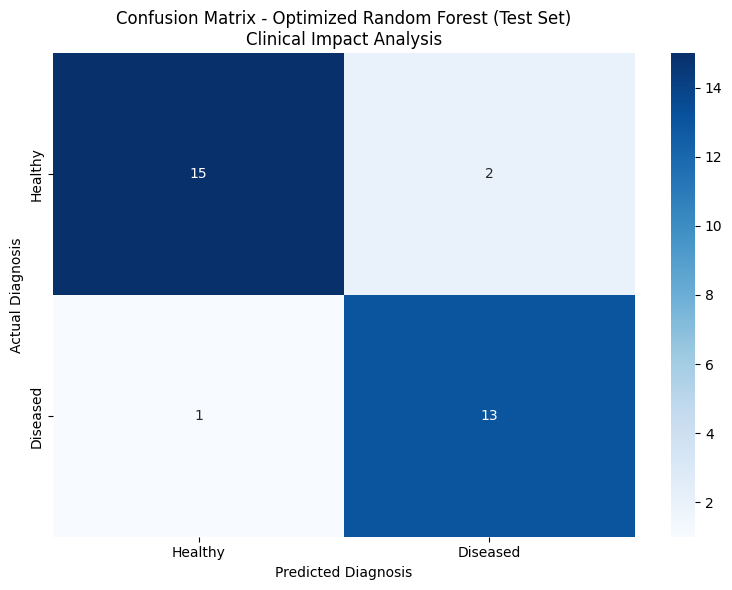

In [15]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

print("ACTUAL vs PREDICTED (Test Set):")
print("                Predicted")
print("              Healthy  Diseased")
print(f"Actual Healthy    {cm[0,0]:>3}       {cm[0,1]:>3}")
print(f"Actual Diseased   {cm[1,0]:>3}       {cm[1,1]:>3}")

# Calculate medically important metrics
total_patients = len(y_test)
true_healthy = cm[0,0] + cm[0,1]
true_diseased = cm[1,0] + cm[1,1]

healthy_correct_pct = cm[0,0] / true_healthy * 100
diseased_correct_pct = cm[1,1] / true_diseased * 100
false_negatives_pct = cm[1,0] / true_diseased * 100  # Missed disease cases
false_positives_pct = cm[0,1] / true_healthy * 100   # False alarms

print(f"\nCLINICAL PERFORMANCE ANALYSIS:")
print(f"Patients correctly identified as healthy: {healthy_correct_pct:.1f}% ({cm[0,0]}/{true_healthy})")
print(f"Patients correctly identified as diseased: {diseased_correct_pct:.1f}% ({cm[1,1]}/{true_diseased})")
print(f"Missed disease cases (false negatives): {false_negatives_pct:.1f}% ({cm[1,0]}/{true_diseased})")
print(f"False alarms (false positives): {false_positives_pct:.1f}% ({cm[0,1]}/{true_healthy})")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Diseased'],
            yticklabels=['Healthy', 'Diseased'])
plt.title('Confusion Matrix - Optimized Random Forest (Test Set)\nClinical Impact Analysis')
plt.ylabel('Actual Diagnosis')
plt.xlabel('Predicted Diagnosis')
plt.tight_layout()
plt.show()

ROC Curve and Precision Recall

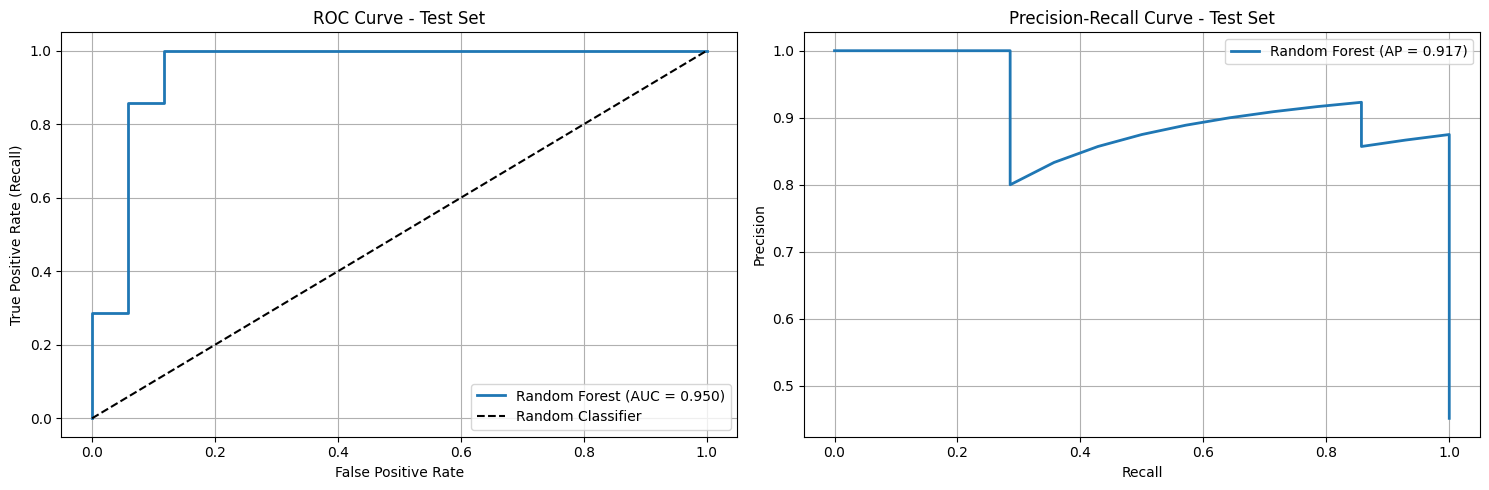

Model demonstrates excellent ranking ability:
 - ROC-AUC: 0.950
 - Average Precision: 0.917


In [16]:
# ROC Curve
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
avg_precision = average_precision_score(y_test, y_test_proba)
plt.plot(recall, precision, label=f'Random Forest (AP = {avg_precision:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Model demonstrates excellent ranking ability:")
print(f" - ROC-AUC: {auc_score:.3f}")
print(f" - Average Precision: {avg_precision:.3f}")

##Save Model

In [17]:
# Save the optimized model
joblib.dump(best_rf, 'heart_disease_final_model.pkl')

# Save the preprocessing pipeline (CRUCIAL for new patients)
preprocessing_artifacts = {
    'label_encoders': label_encoders,
    'feature_names': list(X_train_clean.columns),
    'imputation_values': {'ca': ca_mode_train, 'thal': thal_mode_train}
}
joblib.dump(preprocessing_artifacts, 'preprocessing_pipeline.pkl')

# Save performance metrics
import json

results = {
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'test_precision': precision_score(y_test, y_test_pred),
    'test_recall': recall_score(y_test, y_test_pred),
    'test_f1': f1_score(y_test, y_test_pred),
    'test_auc_roc': roc_auc_score(y_test, y_test_proba),
    'test_average_precision': avg_precision,
    'confusion_matrix': confusion_matrix(y_test, y_test_pred).tolist(),
    'best_parameters': {k: v for k, v in best_rf.get_params().items()
                       if k in ['max_depth', 'min_samples_split', 'min_samples_leaf',
                               'n_estimators', 'max_features', 'class_weight']}
}

with open('model_performance_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save the confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Heart Disease Classification')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

# Save ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.close()

# Precision Recall curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
avg_precision = average_precision_score(y_test, y_test_proba)
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.3f})',
         linewidth=2, color='red')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Heart Disease Classification')
plt.legend()
plt.grid(True, alpha=0.3)
# Add important clinical thresholds
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='High Precision (90%)')
plt.axvline(x=0.9, color='green', linestyle='--', alpha=0.7, label='High Recall (90%)')
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.close()

# Combined ROC and PR Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# ROC Curve
ax1.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)
# Precision-Recall Curve
ax2.plot(recall, precision, label=f'PR (AP = {avg_precision:.3f})', linewidth=2, color='red')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('combined_curves.png', dpi=300, bbox_inches='tight')
plt.close()